## Step 1 Microsoft Azure

*  At least one NVIDIA GPU is needed re-run this code
* This Notebook was run with a [Linux Data Science Virtual Machine](https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/]) on <b>Azure</b> which has GPU, Cuda etc.

In [1]:
# Imports
from fastai import *
from fastai.text import *

In [2]:
# Assure GPU is there 
import torch
print(torch.cuda.set_device(0))
print(torch.cuda.current_device()) # Returns the index of a currently selected device
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

None
0
1
Tesla K80


## Step 2

In [3]:
# Setting batch size - * Attention: language models can use a lot of GPU
bs = 48

## Step 3

In [17]:
# Installing Kaggle API
# import sys
#!{sys.executable} -m pip install kaggle --upgrade
#!pip install kaggle

In [9]:
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

#For Windows, uncomment these two commands
#! mkdir %userprofile%\.kaggle
#! move kaggle.json %userprofile%\.kaggle

mv: cannot stat 'kaggle.json': No such file or directory


In [10]:
# Create a new path for the data?
# path = Config.data_path()/'quora'
# path.mkdir(parents=True, exist_ok=True)
# path

PosixPath('/home/thewoops/.fastai/data/quora')

In [16]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}
#! kaggle competitions download -c quora-insincere-questions-classification

100%|█████████████████████████████████████▉| 6.02G/6.03G [01:18<00:00, 73.0MB/s]
100%|██████████████████████████████████████| 6.03G/6.03G [01:18<00:00, 82.5MB/s]


## Step 4

In [19]:
# from zipfile import ZipFile
# # Create a ZipFile Object and load sample.zip in it
# with ZipFile('quora-insincere-questions-classification.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

## Step 5

In [4]:
pd.set_option('display.max_colwidth', 1500) # inrease display column size
df = pd.read_csv('train.csv')
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [5]:
print(df.shape)
df = df[:10000]
print(df.shape)

(1306122, 3)
(10000, 3)


## Step 6 - Prepare data for LM (create data object out of it)

* fine-tune the pretrained model to our particular dataset
* TextDataBunch does tokenization and numericalization behind the scenes.

In [6]:
import os
path = os.getcwd()
print(path)

/data/home/thewoops/notebooks/fastai/course-v3/my-language-modeling-course


In [19]:
import time
start = time.time()

data_lm = (TextList.from_csv(path, 'train.csv', cols='question_text')
                   #.split_from_df(col='qid') determines how to split the df in train and validation set
                   .split_by_rand_pct(0.1) # split random
                   # .label_from_df(cols='target')
                    .label_for_lm()           
                  #We want to do a language model so we label accordingly
                   .databunch(bs = bs))
data_lm.save('data_lm.pkl')

end = time.time()
print(end-start)

225.3653383255005


We have to use a special kind of `TextDataBunch` for the language model,
    * that ignores the labels (that's why we put 0 everywhere),
    * will shuffle the texts at each epoch before concatenating them all together
      (only for training, we don't shuffle for the validation set)
    * and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [20]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [21]:
data_lm.show_batch()

idx,text
0,"i convert montra xxunk d to a mountain bike by just changing the tyres ? xxbos xxmaj is xxmaj gaza slowly becoming xxmaj auschwitz , xxmaj dachau or xxmaj xxunk for xxmaj palestinians ? xxbos xxmaj why does xxmaj quora automatically ban conservative opinions when reported , but does not do the same for liberal views ? xxbos xxmaj is it crazy if i wash or wipe my groceries off"
1,"anyone in their early thirties and never had like a real relationship with the opposite sex ? xxbos xxmaj can i be an xxmaj english professor after doing xxup ma ? xxbos xxmaj how can we have good terms without any disturbances , xxunk and xxunk ? xxbos xxmaj will a narcissistic sociopath tell derogatory lies about themselves to aide them in the discard stage ? xxbos xxmaj is the"
2,xxmaj what is happening in xxmaj zimbabwe politics ? xxmaj would you explain the rise and fall of xxmaj xxunk regime ? xxbos xxmaj how many marks do you need to get into top 100 in xxmaj manipal university ? xxbos xxmaj how would you react if someone waved you down for help on the side of a highway and it was just because their radio did n't work ?
3,xxmaj why are xxmaj andhra people so much obsessed with caste ? xxmaj are there any major proofs of discrimination in the past history ? xxbos xxmaj which is the best job in xxmaj chandigarh ? xxbos xxmaj what is the funniest thing that has ever happened in a xxmaj model xxmaj united xxmaj nations you have been to ? xxbos xxmaj what was the cut off of xxup nit
4,up xxmaj vietnamese girls if you were xxmaj japanese ? xxbos xxmaj if i am on a shoe string marketing budget should i prioritise xxmaj facebook xxmaj ads over xxmaj blogging or vice versa ? xxbos xxmaj what is your opinion on the press conference done by four senior judges of xxmaj supreme xxmaj court of xxmaj india ? xxmaj was it correct on their part to raise the issue


## Step 7 - Fine-Tune pre-trained model Language Model with quora data

* We can then <b>put this in a learner object very easily with a model loaded with the pretrained weights.</b> They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).
* <b>Here only the last layers of the LM are trained</b>

In [22]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) # pretraied model: AWD-LSTM architecture is used
# dropout 0.3

Learing Rate: How quickly am I updating my weights in my model

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


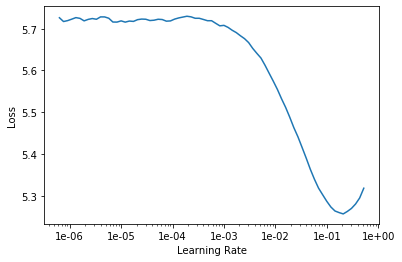

In [24]:
learn.recorder.plot(skip_end=15)

Derive optimal learning rates from the plot

In [26]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.690506,3.557344,0.383129,1:08:08


In [27]:
learn.save('fit_head')

In [28]:
learn.load('fit_head');

## Step 8: Unfreeze and training

To complete the fine-tuning, we unfeeze and launch a new training.

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.386515,3.348693,0.405994,1:16:32
1,3.293854,3.269120,0.415345,1:16:32
2,3.180309,3.242795,0.418656,1:16:28


In [31]:
learn.save('fine_tuned')

In [36]:
learn.save_encoder('fine_tuned_enc')

## Step 9: Classifier

In [32]:
import time
start = time.time()

data_lm = (TextList.from_csv(path, 'train.csv', cols='question_text')
                   #.split_from_df(col='qid') determines how to split the df in train and validation set
                   .split_by_rand_pct(0.1) # split random
                    .label_from_df(cols='target')         
                    #We want to do a language model so we label accordingly
                   .databunch(bs = bs))
data_lm.save('data_clas.pkl')

end = time.time()
print(end-start)

265.82711839675903


In [33]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [34]:
data_clas.show_batch()

text,target
xxbos xxmaj what is [ math ] \ frac { \ xxunk } } \ tan ( \ tan ( { \ boxed { \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk { \ xxunk } } _ { \ xxunk 's xxmaj law of xxmaj theoretical xxmaj probability .,1
xxbos xxmaj what xxup you xxup think xxup that xxup your xxup next xxup bride xxup can xxup have a xxup new xxup hymen xxup post xxup her 6 xxup marriage for xxup fun xxup to xxup be xxup virgin xxup again . xxup ny xxup doctor xxup installs xxup that xxunk $ xxup is xxup sciences ? xxup in xxup thailand the xxup installer do xxup not xxup get,1
"xxbos xxmaj after you delete an app from ipad / iphone , does the app get deleted entirely from the device ? xxmaj as we know , on xxmaj windows , when you are uninstalling a software , you still have some remaining files in the registry , in xxmaj windows / xxmaj program xxmaj files folder , etc .",0
xxbos i have a friend who is in an abusive relationship with her boyfriend . xxmaj he is a jerk who cheats on her and makes her spend a good chunk of her salary on gifts for him . xxmaj but she 's infatuated with him . xxmaj how can i help her see what 's really going on ?,0
"xxbos xxmaj hello ! i have a windows 10 laptop and i can not login to it anymore . i have no password for it , but normally i would have to press the "" connect "" button . xxmaj this button does n't work anymore . xxmaj what is it and what could be done about it ?",0


We can then create a model to classify those reviews and load the encoder we saved before.

In [37]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1175510 items)
x: TextList
xxbos xxmaj how did xxmaj quebec nationalists see their province as a nation in the 1960s ?,xxbos xxmaj do you have an adopted dog , how would you encourage people to adopt and not shop ?,xxbos xxmaj why does velocity affect time ? xxmaj does velocity affect space geometry ?,xxbos xxmaj how did xxmaj otto von xxmaj guericke used the xxmaj magdeburg hemispheres ?,xxbos xxmaj can i convert montra xxunk d to a mountain bike by just changing the tyres ?
y: CategoryList
0,0,0,0,0
Path: /data/home/thewoops/notebooks/fastai/course-v3/my-language-modeling-course;

Valid: LabelList (130612 items)
x: TextList
xxbos xxmaj can i switch my xxmaj canadian student visa into visitor visa ?,xxbos xxmaj how do you manage stress when you have an exam the next day ?,xxbos xxmaj which country is the most friendly in starting a company ?,xxbos xxmaj why did xxmaj nintendo choose xxup usb xxmaj type c for the xxmaj nintendo xxma

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


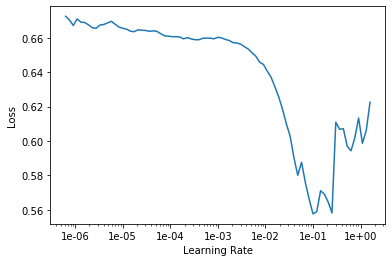

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.249518,0.216909,0.938574,18:46


In [41]:
learn.save('first')

In [42]:
learn.load('first');

## Step 10: Prediction

In [43]:
learn.predict("why does pakistan support terrorism")

(Category 0, tensor(0), tensor([0.9577, 0.0423]))

## Step 11: Evaluation

to be defined..
https://forums.fast.ai/t/f1-score-as-metric/30370